## Structural clustering MHC Class I bound peptides using voxel representations and HDBSCAN

### Aims

### Method

### Results

### Conclusions

### Caveats/notes

### 1. Importing libraries and functions and loading configuration


In [1]:
# imports used in the notebook

import json
import os
import requests
import time
import hashlib

import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'white'

from hdbscan import HDBSCAN

from functions.helpers import load_config, deslugify_allele
from functions.structures import fetch_structure_info, download_structure, load_pdb_file_to_dataframe
from functions.voxels import create_voxel_grid, find_voxels_for_structure



# load the config file to populate the configuration variables dictionary
# Note: if you change the shape and parameters of the voxel map, you will need to update the config file with the new voxel_map_hash

config = load_config()

# output the config file to the console
config

{'canonical_pdb_code': '1hhk',
 'centre_of_mass': [-42.365, 56.031, 63.67],
 'excluded_structures': ['2gtw', '4lcy'],
 'test_pdb_codes': ['1hhg', '1hhi', '1hhj', '1hhk'],
 'voxel_size': 1,
 'box_xyz': [36, 20, 20],
 'base_url': 'https://coordinates.histo.fyi/structures/downloads/class_i/without_solvent',
 'offsets': {'x': 0, 'y': 0, 'z': 0},
 'voxel_map_hash': 'e91d9bdc62da8457549cfbeed4c2b0aa'}

## 2. Fetch the structures to be clustered. 


In [2]:
sql_query = "select pdb_code, locus, allele_slug, peptide_sequence, resolution from core where peptide_length='9' and peptide_features='correct_sequence_and_length' and complex_type='class_i_with_peptide' and (locus='hla-a' or locus='hla-b' or locus='hla-c') order by resolution asc"

# the only_highest_resolution flag is set to False, so all structures will be returned, not just the highest resolution ones
structure_info = fetch_structure_info(sql_query, config['excluded_structures'], only_highest_resolution=False)

print (structure_info['metadata'])

print (f"There are {len(structure_info['structures'])} structures in the dataset.")

# TODO add a check to make sure that we're not removing structures with different conformations. 
# TODO add in getting more structures to test (e.g. if there are _1, _2, etc. structures, get those too)
# TODO add in some way of checking alternate atom locations (e.g. A, B, C, etc.)

if structure_info['metadata']['only_highest_resolution']:
    print (f"{structure_info['metadata']['original_structure_count'] - structure_info['metadata']['only_highest_resolution_count']} lower resolution duplicate structures have been removed.")

pdb_code_list = list(structure_info['structures'].keys())




{'excluded_structures': ['2gtw', '4lcy'], 'sql_query': "select pdb_code, locus, allele_slug, peptide_sequence, resolution from core where peptide_length='9' and peptide_features='correct_sequence_and_length' and complex_type='class_i_with_peptide' and (locus='hla-a' or locus='hla-b' or locus='hla-c') order by resolution asc", 'original_structure_count': 332, 'only_highest_resolution_count': None, 'only_highest_resolution': False}
There are 332 structures in the dataset.


## 3. Analyse the diversity of the structures (or lack of it)

Unsurprisingly there are a lot of HLA-A*02:01 structures in the collection. So many so that HLA-B structures would outnumber HLA-A structures if they are removed. Obviously this is a significant bias and this should be considered when looking at clusters later in the notebook.

Number of structures containing HLA-A*02:01: 140




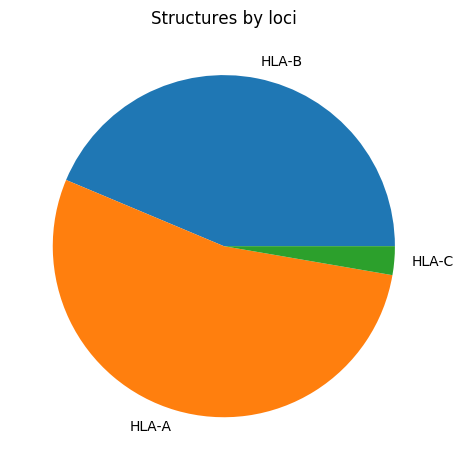

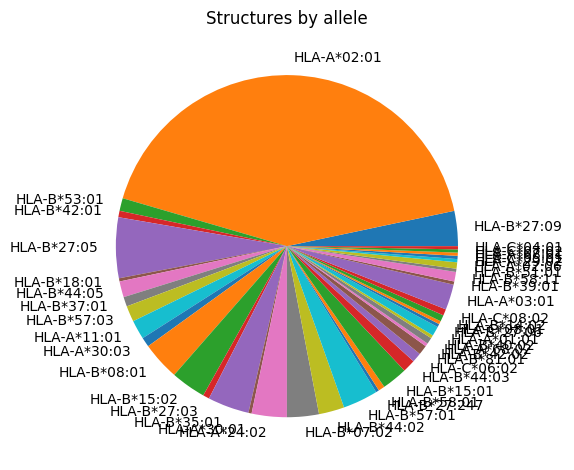

In [3]:
loci = {}
alleles = {}

for pdb_code in pdb_code_list:
  locus = structure_info['structures'][pdb_code]['locus']
  allele_slug = structure_info['structures'][pdb_code]['allele_slug']

  if locus not in loci:
    loci[locus] = 0
  loci[locus] += 1

  if allele_slug not in alleles:
    alleles[allele_slug] = 0
  alleles[allele_slug] += 1



# Create plots of number of structures per locus

fig, ax = plt.subplots()
ax.pie(loci.values(), labels=[locus.upper() for locus in loci.keys()])
ax.set_title('Structures by loci')
plt.tight_layout()

print (f"Number of structures containing HLA-A*02:01: {alleles['hla_a_02_01']}\n\n")

# Create plots of number of structures per allele

fig, ax = plt.subplots()
ax.pie(alleles.values(), labels=[deslugify_allele(allele_slug) for allele_slug in alleles.keys()])
ax.set_title('Structures by allele')
plt.tight_layout()



## 4. Looking at peptide diversity in the set of structures

Some peptides sequences are represented in structures with multiple alleles. Some peptides have structures with similar peptide sequences.

We're going to use the IEDB Cluster API to give us a data table of peptide clusters. 

Then we're going to process that to look at the number of structures for that particular peptide cluster. 

Then we're going to plot those clusters by cluster size and number of structures in that cluster. 



In [4]:



peptide_dict = {}

for pdb_code in pdb_code_list:
  peptide = structure_info['structures'][pdb_code]['peptide']
  if peptide not in peptide_dict:
    peptide_dict[peptide] = []
  peptide_dict[peptide].append(pdb_code)

sequences = list(peptide_dict.keys())

print (f"There are {len(sequences)} unique peptide sequences in the dataset.")

iedb_url = "https://api-nextgen-tools.iedb.org/api/v1/pipeline"

iedb_payload = {
  "pipeline_id": "",
  "run_stage_range": [
    1,
    1
  ],
  "stages": [
    {
      "name": "Cluster",
      "stage_number": 1,
      "tool_group": "cluster",
      "input_sequence_text": '\n'.join(sequences),
      "input_parameters": {
        "cluster_pct_identity": 0.5,
        "peptide_length_range": [
          9,
          9
        ],
        "predictors": [
          {
            "type": "cluster",
            "method": "cliques"
          }
        ]
      }
    }
  ]
}

iedb_response = requests.post(iedb_url, json=iedb_payload)

iedb_response_json = iedb_response.json()

iedb_results_uri = iedb_response_json['results_uri']

print (f"IEDB clustering job '{iedb_response_json['result_id']}' started.")

iedb_results_json = {'status': 'running'}

while iedb_results_json['status'] != 'done':
  iedb_results = requests.get(iedb_results_uri)
  iedb_results_json = iedb_results.json()

  print (f"IEDB clustering job '{iedb_results_json['id']}' is {iedb_results_json['status']}")

  if iedb_results_json['status'] in ['started', 'pending']:
    time.sleep(5)




There are 238 unique peptide sequences in the dataset.
IEDB clustering job '1067c588-0fca-444c-9fde-383828b56044' started.
IEDB clustering job '1067c588-0fca-444c-9fde-383828b56044' is pending
IEDB clustering job '1067c588-0fca-444c-9fde-383828b56044' is pending
IEDB clustering job '1067c588-0fca-444c-9fde-383828b56044' is pending
IEDB clustering job '1067c588-0fca-444c-9fde-383828b56044' is done


262


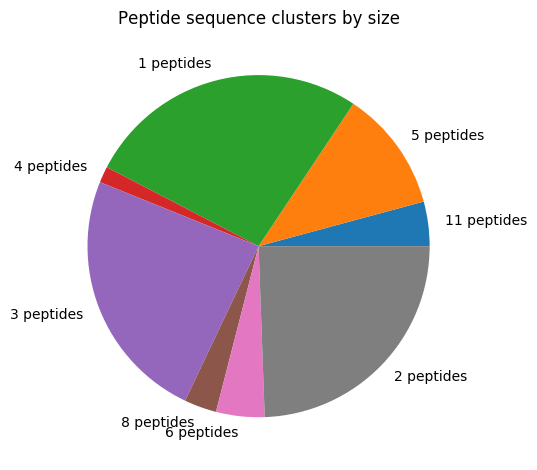

In [5]:
table_data = iedb_results.json()['data']['results'][0]['table_data']

raw_clusters = {}

cluster_sizes = {}

peptide_count = 0

for row in table_data:
    cluster_id = row[0]
    if not cluster_id in raw_clusters:
        raw_clusters[cluster_id] = {'consensus': None, 'members': [], 'size': 0}
    if not 'Consensus' in row[1]:
        if not row[2] in raw_clusters[cluster_id]['members']:
            raw_clusters[cluster_id]['members'].append(row[2])
            raw_clusters[cluster_id]['size'] += 1
            peptide_count += 1
    else:
        raw_clusters[cluster_id]['consensus'] = row[2]
    

print (peptide_count)

for cluster in raw_clusters:
    cluster_size = raw_clusters[cluster]['size']
    if not cluster_size in cluster_sizes:
        cluster_sizes[cluster_size] = {'count': 0, 'canonicals': [], 'total': 0}
    cluster_sizes[cluster_size]['count'] += 1
    if raw_clusters[cluster]['consensus']:
        cluster_sizes[cluster_size]['canonicals'].append(raw_clusters[cluster]['consensus'])
        
    else:
        cluster_sizes[cluster_size]['canonicals'].append(raw_clusters[cluster]['members'][0])
    cluster_sizes[cluster_size]['total'] += cluster_size


labels = [f"{item} peptides" for item in list(cluster_sizes.keys())]
sizes = [cluster_sizes[label]['total'] for label in list(cluster_sizes.keys())]

labels, sizes

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
ax.set_title('Peptide sequence clusters by size')
plt.tight_layout()


## 5. Creating the voxel grid



In [6]:
# create the voxel grid, we only need to do this once, so it's outside the loop
voxel_grid = create_voxel_grid(config['centre_of_mass'], config['box_xyz'], config['voxel_size'], range_offset=1, y_offset=8)

voxel_grid_hash = hashlib.md5(str(voxel_grid).encode()).hexdigest()

voxel_set_filepath = f"output/voxel_sets/{voxel_grid_hash}"

if not os.path.exists(voxel_set_filepath):
    os.mkdir(voxel_set_filepath)
    print (f"Created directory {voxel_set_filepath}\n")

with open(f"{voxel_set_filepath}/voxel_set.json", 'w') as filehandle:
    json.dump(voxel_grid, filehandle, indent=4)
    print (f"Voxel set saved to {voxel_set_filepath}/voxel_set.json\n")

print (f"Voxel set hash for this grid is: {voxel_grid_hash}")

Voxel set saved to output/voxel_sets/e91d9bdc62da8457549cfbeed4c2b0aa/voxel_set.json

Voxel set hash for this grid is: e91d9bdc62da8457549cfbeed4c2b0aa


## 6. Downloading the structures

In [7]:
structure_count = 0
download_count = 0
cached_count = 0
errors = []

structure_dataset = {}

for pdb_code in pdb_code_list:
    structure_data, downloaded, cached, error  = download_structure(pdb_code, config)
    if downloaded:
        download_count += 1
    if cached:
        cached_count += 1
    if error:
        print (error)
        errors.append(pdb_code)
    else:
        structure_dataset[pdb_code] = structure_data
    structure_count += 1

print (f"{structure_count} structures were processed. {download_count} structures were downloaded, {cached_count} structures were already downloaded, and {len(errors)} errors occurred.")


332 structures were processed. 0 structures were downloaded, 332 structures were already downloaded, and 0 errors occurred.


## 7. Processing the structures (finding the occupied voxels) 

In [10]:
voxelized_structures = []

# iterate through the test PDB codes
for pdb_code in pdb_code_list:

    # load the peptide dataframe for the PDB code
    dataframe = load_pdb_file_to_dataframe(pdb_code, 'peptide', config)
    
    if dataframe:
    # if the dataframe is not None, find the voxels for the structure and write them to a file
        structure_voxels = find_voxels_for_structure(dataframe, voxel_grid['voxels'], voxel_size=config['voxel_size'])

        voxel_data = {
            'voxel_grid_hash': voxel_grid_hash,
            'structure_voxels': structure_voxels
        }

        filename = f"{voxel_set_filepath}/{pdb_code}.json"

        with open(filename, 'w') as filehandle:
            json.dump(voxel_data, filehandle, indent=4)
        voxelized_structures.append(pdb_code)

print (f"{len(voxelized_structures)} structures were processed and saved to {voxel_set_filepath}")

332 structures were processed and saved to output/voxel_sets/e91d9bdc62da8457549cfbeed4c2b0aa


## 8. Looking at positional voxel occupancy


In [ ]:
# TODO move over from other notebook

## 9. Looking at occupancy of neighbouring voxels

## 10. Clustering the voxels using HDBSCAN

In [ ]:
# TODO move over from Python files

## 11. Analysing the peptide clusters

In [ ]:
# TODO work on this section

## 12. Displaying the peptide clusters

In [ ]:
# TODO work on this section, bring over from alphafold analysis notebook

## 13. Analysing the allele patterns within the peptide clusters

In [ ]:
# TODO work on this section 

## 14. Analysing the peptide patterns within the peptide clusters

In [ ]:
# TODO work on this section

## 15. Clusters of interest

### Notes:



## 16. Future directions

Look at side chain centre of mass as an additional factor/sub-classification
